# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1HSrSmlsGd90Nvj-FopjWit67Msp5rVie?usp=sharing

In [4]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [5]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [6]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

<ipython-input-6-037957db2593>:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [7]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [9]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [10]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [11]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

In [12]:
# calculate min, max, average
print("age: \nmax = " + str(np.max(subdf["age"])) + "\nmin = " + str(np.min(subdf["age"])) + "\nmean = " + str(np.mean(subdf["age"])))
print("\nyredu: \nmax = " + str(np.max(subdf["yredu"])) + "\nmin = " + str(np.min(subdf["yredu"])) + "\nmean = " + str(np.mean(subdf["yredu"])))
print("\ncapgain: \nmax = " + str(np.max(subdf["capgain"])) + "\nmin = " + str(np.min(subdf["capgain"])) + "\nmean = " + str(np.mean(subdf["capgain"])))
print("\ncaploss: \nmax = " + str(np.max(subdf["caploss"])) + "\nmin = " + str(np.min(subdf["caploss"])) + "\nmean = " + str(np.mean(subdf["caploss"])))
print("\nworkhr: \nmax = " + str(np.max(subdf["workhr"])) + "\nmin = " + str(np.min(subdf["workhr"])) + "\nmean = " + str(np.mean(subdf["workhr"])))

age: 
max = 90
min = 17
mean = 38.58164675532078

yredu: 
max = 16
min = 1
mean = 10.0806793403151

capgain: 
max = 99999
min = 0
mean = 1077.6488437087312

caploss: 
max = 4356
min = 0
mean = 87.303829734959

workhr: 
max = 99
min = 1
mean = 40.437455852092995


In [13]:
# Calculate min and max
min_vals = df[["age", "yredu", "capgain", "caploss", "workhr"]].min()
max_vals = df[["age", "yredu", "capgain", "caploss", "workhr"]].max()

# normalize (x-xmin/xmax-xmin)
df[["age", "yredu", "capgain", "caploss", "workhr"]] = (df[["age", "yredu", "capgain", "caploss", "workhr"]] - min_vals) / (max_vals - min_vals)

### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [14]:
# hint: you can do something like this in pandas
males = sum(df["sex"] == " Male")
females = sum(df["sex"] == " Female")
total = males + females

In [15]:
print(str((males/total)*100) + "% of people are male")
print(str((females/total)*100) + "% of people are female")

66.92054912318419% of people are male
33.07945087681583% of people are female


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [16]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [17]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [18]:
print(str(len(df_with_missing)) + " records contained missing features")
print(str((len(df_with_missing)/len(df_with_missing + df_not_missing))*100) + "% of records were removed")

1843 records contained missing features
5.660145572924664% of records were removed


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [19]:
set(df_not_missing['work'])

{' Federal-gov',
 ' Local-gov',
 ' Private',
 ' Self-emp-inc',
 ' Self-emp-not-inc',
 ' State-gov',
 ' Without-pay'}

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [20]:
data = pd.get_dummies(df_not_missing)

In [21]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,0.452055,0.800000,0.00000,0.0,0.122449,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
2,0.287671,0.533333,0.00000,0.0,0.397959,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,True


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [22]:
print("There are " + str(len(data.columns)) + " columns in the dataframe data")

There are 57 columns in the dataframe data


The number 57 comes from the number of features in the dataframe data. For example, these would include age, yredu, work_Federal-gov, work_Local-gov, edu_Prof-school, etc...

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [23]:
datanp = data.values.astype(np.float32)

In [24]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values`
    # (created above) useful.
    index = np.argmax(onehot)
    feature_val = cat_values[feature]
    name = feature_val[index]
    return name

In [25]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [26]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
np.random.shuffle(datanp)
train_ind = int(0.7 * len(datanp))
val_ind = int(0.85 * len(datanp))

train_set = datanp[:train_ind]
val_set = datanp[train_ind:val_ind]
test_set = datanp[val_ind:]

In [27]:
print("There are " + str(len(train_set)) + " items in the training set")
print("There are " + str(len(val_set)) + " items in the validation set")
print("There are " + str(len(test_set)) + " items in the test set")

There are 21502 items in the training set
There are 4608 items in the validation set
There are 4608 items in the test set


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [28]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.name = "autoencoder"
        self.encoder = nn.Sequential(
            nn.Linear(57, 44),
            nn.ReLU(),
            nn.Linear(44, 22),
            nn.ReLU(),
            nn.Linear(22, 11)
        )
        self.decoder = nn.Sequential(
            nn.Linear(11, 22),
            nn.ReLU(),
            nn.Linear(22, 44),
            nn.ReLU(),
            nn.Linear(44, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

There is a sigmoid activation in the last step of the decoder because the output of the decoder should match the format of the input values from the dataframe data which are all values in the range (0, 1). The sigmoid activation ensures that the final output is normalized from (0, 1).

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [29]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def get_loss(model, loader, criterion):
    """ Calculates and returns the loss of the model for the respective data loader
    """
    total_loss = 0.0
    i = 0
    for data in loader:
        datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
        recon = model(datam)
        loss = criterion(recon, data)
        total_loss += loss.item()
        i+=1
    loader_loss = float(total_loss) / (i+1)
    return loader_loss

def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation accuracy/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def get_model_name(name, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_lr{1}_epoch{2}".format(name,
                                              learning_rate,
                                              epoch)
    return path

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""

    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    total_train_loss = 0.0
    i = 0

    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_train_loss += loss.item()
            i+=1

# calculating the accuracy and loss averages and appending to the arrays
        train_acc[epoch] = get_accuracy(model, train_loader)
        train_loss[epoch] = float(total_train_loss)/ (i+1)
        val_acc[epoch] = get_accuracy(model, valid_loader)
        val_loss[epoch] = get_loss(model, valid_loader, criterion)

        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
                  "Validation acc: {}, Validation loss: {}").format(
                      epoch + 1,
                      train_acc[epoch],
                      train_loss[epoch],
                      val_acc[epoch],
                      val_loss[epoch]))

# Save the current model (checkpoint) to a file
    model_path = get_model_name(model.name, learning_rate, epoch)
    torch.save(model.state_dict(), model_path)
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    plot_training_curve(model_path)

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [30]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

In [27]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, num_workers=1, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, num_workers=1, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, num_workers=1, shuffle = True)

Epoch 1: Train acc: 0.5444609803739187, Train loss: 0.0875577543273524 |Validation acc: 0.5465133101851852, Validation loss: 0.05453798562696535
Epoch 2: Train acc: 0.5664821877034695, Train loss: 0.06851536118014429 |Validation acc: 0.5696976273148148, Validation loss: 0.04503573028192128
Epoch 3: Train acc: 0.5969057141971289, Train loss: 0.059828605333009016 |Validation acc: 0.5954861111111112, Validation loss: 0.03828441438405481
Epoch 4: Train acc: 0.5850386010603664, Train loss: 0.05436250148375681 |Validation acc: 0.58203125, Validation loss: 0.03676271423289221
Epoch 5: Train acc: 0.6048972188633616, Train loss: 0.050651768816370187 |Validation acc: 0.6048177083333334, Validation loss: 0.03402676338916772
Epoch 6: Train acc: 0.5983009332465197, Train loss: 0.047740415012926585 |Validation acc: 0.5953052662037037, Validation loss: 0.03264219676182695
Epoch 7: Train acc: 0.6061606672247543, Train loss: 0.04540453145428511 |Validation acc: 0.6013816550925926, Validation loss: 0.03

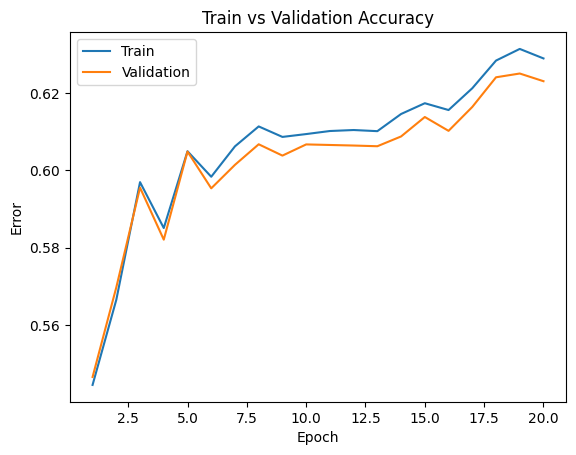

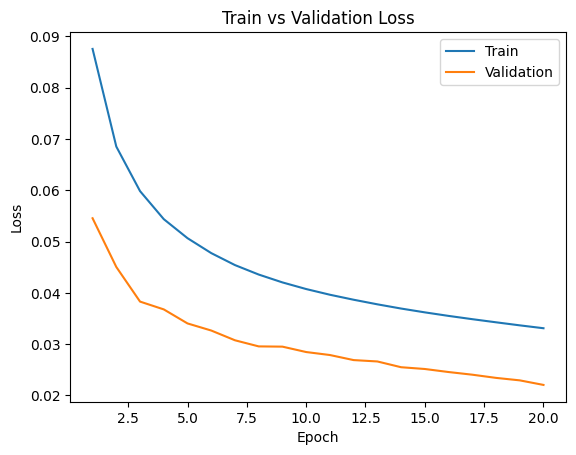

In [28]:
autoencoder = AutoEncoder()
train(autoencoder, train_loader, val_loader, num_epochs=20, learning_rate=0.001)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.

In [ ]:
# We can try increasing the number of epochs from 20 to 40 to see if the model accuracy continues to increase
model_2 = AutoEncoder()
train(model_2, train_loader, val_loader, num_epochs=40, learning_rate=0.001)
# final training accuracy: 61.3%
# final validation accuracy: 61.2%
# accuracies decreased, so increasing the number of epochs didn't help as the accuracies still converge to about 61-62%

In [ ]:
# The previous model accuracies were fluctuating/noisy, so we can try decreasing the learning rate from 0.001 to 0.0001 to reduce noise
# Go back to 20 epochs as increasing the num_epochs did not help in model_2
model_3 = AutoEncoder()
train(model_3, train_loader, val_loader, num_epochs=20, learning_rate=0.0001)
# The decreased learning rate reduced the noise significantly, however, the training and validation accuracies decreased to about 58.4% and 58.3% respectively

In [31]:
# The validation loss curve for all of these models is lower than the training loss curve. (maybe the validation set is easier than the training set)
# We could try reducing the complexity of the model (number of layers) to see if this would decrease the training loss.
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.name = "autoencoder"
        self.encoder = nn.Sequential(
            nn.Linear(57, 28),
            nn.ReLU(),
            nn.Linear(28, 11)
        )
        self.decoder = nn.Sequential(
            nn.Linear(11, 28),
            nn.ReLU(),
            nn.Linear(28, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# train the model after reducing the number of layers
model_4 = AutoEncoder()
train(model_4, train_loader, val_loader, num_epochs=20, learning_rate=0.0001)
# this didn't change much, the training and validation accuracies are still at around 58%

In [43]:
# Since reducing the number of layers didn't change the model's performance very much, we can try changing the number of hidden units
# This change will hopefully help our model capture more complex patterns and increase the training and validation accuracies
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.name = "autoencoder"
        self.encoder = nn.Sequential(
            nn.Linear(57, 44),
            nn.ReLU(),
            nn.Linear(44, 11)
        )
        self.decoder = nn.Sequential(
            nn.Linear(11, 44),
            nn.ReLU(),
            nn.Linear(44, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# Training the new model
model_5 = AutoEncoder()
train(model_5, train_loader, val_loader, num_epochs=20, learning_rate=0.001)
# Increasing the number of hidden units helped the model reach higher training and validation accuracies of 63.8% and 63.1% respectively.
# It also helped lower the final training loss from the previous model's 0.065 to 0.023

In [ ]:
# Since the training and validation accuracies were still increasing near the end (epoch 20), I increased the number of epochs to 30 to see if the
# values would start to converge. I also increased the learning rate to 0.01 to speed up the process.
model_6 = AutoEncoder()
train(model_6, train_loader, val_loader, num_epochs=30, learning_rate=0.01)
# This increased the training accuracy to 70.5% and the validation accuracy to 70.1%

Epoch 1: Train acc: 0.6080907202430782, Train loss: 0.04179625214251637 |Validation acc: 0.6059751157407407, Validation loss: 0.023106585754311248
Epoch 2: Train acc: 0.6227947787802685, Train loss: 0.03080749641522699 |Validation acc: 0.6211660879629629, Validation loss: 0.017387430642871824
Epoch 3: Train acc: 0.6124158992961894, Train loss: 0.025934358164335796 |Validation acc: 0.6106409143518519, Validation loss: 0.015490335769543093
Epoch 4: Train acc: 0.609237900350355, Train loss: 0.02313159450847088 |Validation acc: 0.6091218171296297, Validation loss: 0.015088134228366695
Epoch 5: Train acc: 0.6412581775338728, Train loss: 0.021219612880411035 |Validation acc: 0.6355975115740741, Validation loss: 0.013130232557807474
Epoch 6: Train acc: 0.6379716615508635, Train loss: 0.01989763161101936 |Validation acc: 0.6328486689814815, Validation loss: 0.013639113030154002
Epoch 7: Train acc: 0.6465832635723808, Train loss: 0.01890605142837983 |Validation acc: 0.6408058449074074, Validati

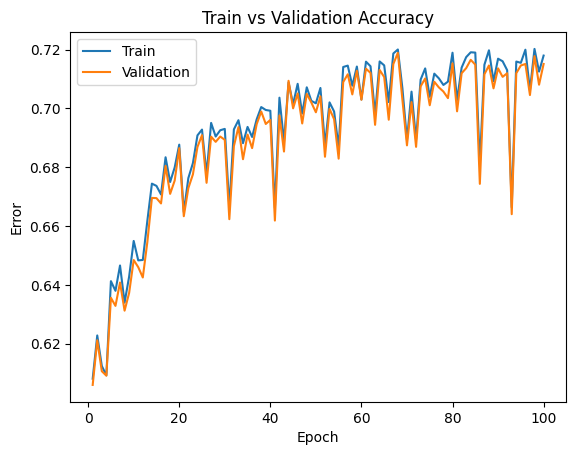

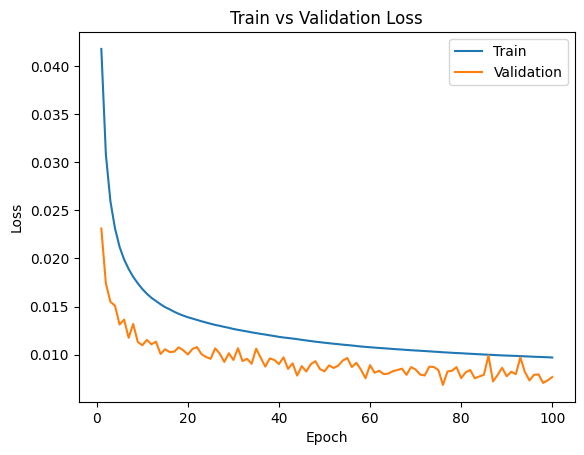

In [45]:
# Increasing the number of epochs to 100 because the accuracies were still increasing
model_7 = AutoEncoder()
train(model_7, train_loader, val_loader, num_epochs=100, learning_rate=0.01)
# Reached training accuracy of 71.8% and validation accuracy of 71.5%
# The curves are quite noisy, so we'll decrease the learning rate a bit for the next model

In [ ]:
# Decreased the learning rate to 0.00001 and increased the number of epochs to 150 to see if we could achieve less noise and similar accuracies
model_8 = AutoEncoder()
train(model_8, train_loader, val_loader, num_epochs=150, learning_rate=0.00001)
# Much less noise, but the training and validation accuracies decreased to 60.4% and 60.5%

Chose model_7 as the final model, because it reached the highest training and validation accuracies.

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [49]:
test_acc = get_accuracy(model_7, test_loader)
print("The test accuracy is " + str(test_acc*100) + "%")

The test accuracy is 71.19140625%


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set.

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [31]:
most_common_values = {}
for col in catcols:
    most_common_values[col] = df[col].mode()[0]

In [32]:
most_common_values

{'work': ' Private',
 'marriage': ' Married-civ-spouse',
 'occupation': ' Prof-specialty',
 'edu': ' HS-grad',
 'relationship': ' Husband',
 'sex': ' Male'}

In [35]:
def baseline_model(most_common_values, feature):
  matches = 0
  total_records = len(df_not_missing[feature])

  for idx in range(total_records):
      if df_not_missing[feature].iloc[idx] == most_common_values[feature]:
          matches += 1

  baseline_acc = matches / total_records
  print("The baseline model accuracy of the \"" + str(feature) + "\" feature is " + str(baseline_acc*100) + "%")


In [36]:
baseline_model(most_common_values, "marriage")
baseline_model(most_common_values, "edu")
baseline_model(most_common_values, "work")
baseline_model(most_common_values, "occupation")
baseline_model(most_common_values, "relationship")
baseline_model(most_common_values, "sex")

The baseline model accuracy of the "marriage" feature is 46.67947131974738%
The baseline model accuracy of the "edu" feature is 32.450029298782475%
The baseline model accuracy of the "work" feature is 73.88501855589557%
The baseline model accuracy of the "occupation" feature is 13.47743993749593%
The baseline model accuracy of the "relationship" feature is 41.35685917051891%
The baseline model accuracy of the "sex" feature is 67.67367667165831%


If you average all the feature accuracies, you get an overall accuracy of 45.92%.

### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

The accuracy from part (a) is 71.2% and the accuracy for part (b) is 45.92%. Therefore, the accuracy from our autoencoder model is much higher than the baseline model accuracy.

### Part (d) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [93]:
get_features(test_set[0])

{'work': 'Private',
 'marriage': 'Divorced',
 'occupation': 'Prof-specialty',
 'edu': 'Bachelors',
 'relationship': 'Not-in-family',
 'sex': 'Male'}

No, I don't think it's reasonable. Personally, if I were to estimate someone's education level, I would primarily look at occupation and work because I think features such as marriage and relationship have much less of an impact on their education level. However, from this person's occupation: 'Prof-specialty', I would've assumed they had higher than a bachelors because in my opinion you need a lot of experience/research to be a specialist at something. Overall, I think different people would have given different predictions for this person's education level (biased depending on the person and how much they weigh the importance of each feature to the one they are predicting).

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [100]:
zero_edu = torch.from_numpy(zero_out_feature(test_set[:1], "edu")[0])
predict = model_7(zero_edu)
get_feature(predict.detach().numpy(), "edu")

'Bachelors'

model_7's prediction of this person's education level is Bachelors, which is correct.

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [107]:
most_common_values["edu"]

' HS-grad'

The baseline model's prediction of this person's education level is HS-grad, which is incorrect (majority of the people the data was collected from were high school graduates).